In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal
# plt.style.use(['science', 'notebook', 'grid'])

# The Time-Dependent Schrodinger Equation

The Time Dependent Schrodinger Equation (in a position basis with infinite boundaries) is 

$$ i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) \hspace{20mm} \psi(0, t) = \psi(L,t)=0 $$

We don't need to deal with extra parameters like $m$, $\hbar$, etc. Multiplying both sides by $mL^2$ where $L$ is the characteristic length of the problem (here we are bounded in length $L$)

$$ i mL^2 \hbar \frac{\partial}{\partial t} \psi = -\frac{1}{2}\hbar^2 L^2\frac{\partial^2}{\partial x^2}\psi + mL^2V(x) \psi $$

Now choose the convention $\hbar=1$ (So Joules=1/Seconds) and make the transformation

* $x'=\frac{x}{L}$
* $t' = \frac{t}{mL^2}$
* $V' = mL^2V$

You can check that with the convention $\hbar=1$, all of the three quantities above are dimensionless. The Schrodinger equation with respect to these three variables becomes

$$ i \frac{\partial}{\partial t'} \psi = -\frac{1}{2}\frac{\partial^2}{\partial x'^2}\psi + V'(x) \psi $$

We solve this equation for $x'$ and $t'$ and then solve for $x$ and $t$ using 

* $x = Lx'$
* $t = (mL^2) t'$
* $V = (mL^2)^{-1} V'$

**For all the numerical work we will drop the primes on $x'$, $t'$, and $V'$ but know that we are working with the primed quantities**

# Technique 1: Finite Difference

Choose a discrete grid with spacing $\Delta x$ and $\Delta t$ and let $\psi_j^{m} = \psi(j\Delta x, m\Delta t)$

$$i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{1}{2}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +V(x)\psi_j^m$$ 

Rearrange the equation

$$\psi_{j}^{m+1} = \psi_j^m + \frac{i}{2}\frac{\Delta t}{\Delta x^2}\left(\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}\right) - i \Delta tV(x)\psi_j^m$$ 

# Technique 2: Eigenstate Evolution

Find the $\psi_j$ and $E_j$'s that satisfy

$$ -\frac{1}{2}\frac{\partial^2}{\partial x^2}\psi + V(x) \psi = E\psi$$

And then

$$\psi(x,t) = \sum_{j=0}^\infty c_j \psi_j(x) e^{-i E_j t} \hspace{20mm} c_j = \int_{-\infty}^{\infty} \psi(x, 0)\psi_j^*(x) dx$$

# Technique 1

Define all parameters of interest.

In [3]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)

In [4]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

Look at $dt/dx^2$ (this parameter should be small for the finite difference method to work).

In [5]:
dt/dx**2

0.008999999999999998

The (dimensionless) potential we examine here is

$$V(x) = -10^4 \exp{\left(\frac{-(x-L/2)^2}{2(L/20)^2}\right)}$$

which is essentially just a normal curve which can be specified more simply as $V(x) = -n(x, \mu=L/2, \sigma=L/20)$

Text(0, 0.5, '$V(x)$')

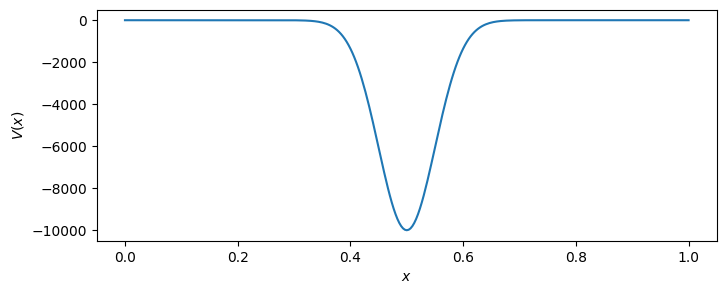

In [6]:
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

Construct the array of $\psi(x,t)$ (two dimensions: one for $x$ and one for $t$)

In [7]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [8]:
psi

array([[0.00000000e+00, 1.48093391e-02, 2.96170542e-02, ...,
        2.96170542e-02, 1.48093391e-02, 1.73191211e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Numba algorithm to implement the finite difference method

In [9]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

Compute $\psi(x,t)$ using method 1 (so we label m1)

In [10]:
psi_m1 = compute_psi(psi.astype(complex))

Plot for some given $m=10000$ (the dimensionless time is $t=m\Delta t$)

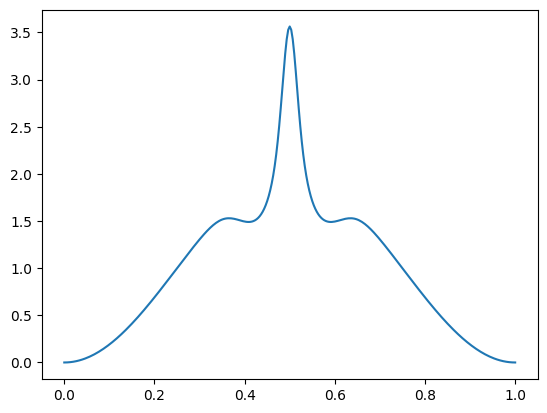

In [11]:
plt.plot(x, np.absolute(psi_m1[5000])**2)
#np.sum(np.absolute(psi_m1[10000])**2)*dx

# Technique 2

Create the grid and define the initial condition $\psi(x,0)$

In [12]:
Nx = 301
dx = 1/(Nx-1)
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)

def V(x):
    mu, sigma = 1/2, 1/20
    return -1e4*np.exp(-(x-1/2)**2/(2*(1/20)**2))

Define the tridiagonal matrix required for solving for the eigenstates (see https://www.youtube.com/watch?v=ay0zZ8SUMSk for solving the time-independent Schrodinger equation, which is what we're doing here)

In [13]:
d = 1/dx**2 + V(x)[1:-1]
e = -1/(2*dx**2) * np.ones(len(d)-1)
w, v = eigh_tridiagonal(d, e)

Compute eigenstates $\psi_j$ and eigen-energies $E_j$, and use $$\psi(x,t) = \sum_{j=0}^\infty c_j \psi_j(x) e^{-i E_j t} \hspace{20mm} c_j = \int_{-\infty}^{\infty} \psi(x, 0)\psi_j^*(x) dx$$ to get the $\psi(x,t)$

In [14]:
E_js = w[0:70]
psi_js = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode='constant')
cs = np.dot(psi_js, psi0)
def psi_m2(t):
    return psi_js.T@(cs*np.exp(-1j*E_js*t))

Plot the energy at time $t = 10000 \Delta t$

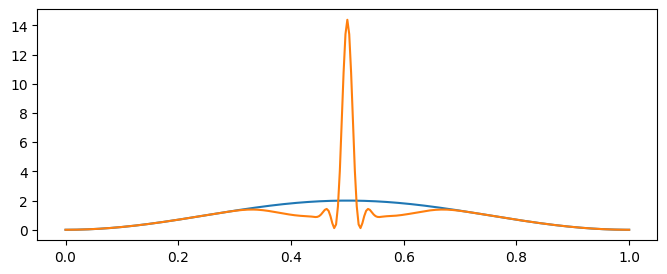

In [15]:
plt.figure(figsize=(8,3))
plt.plot(x, psi0**2)
plt.plot(x, np.absolute(psi_m2(10000*dt))**2)

# Animation

Now we make an animation that shows the results of the two techniques, and that they give the same result.

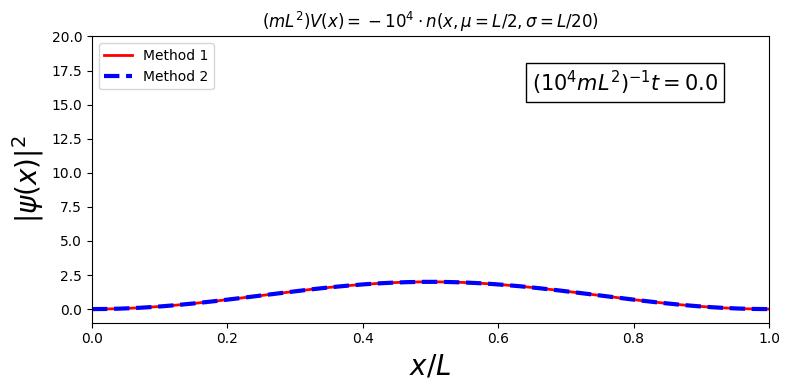

In [16]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    ln2.set_data(x, np.absolute(psi_m2(100*i*dt))**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('1d_seredinger_time_depended.gif',writer='pillow',fps=50,dpi=100)

# How to Get Things in SI Units?

We're currently in the unit system $\hbar=1$ but what if we want to go back to SI units?


## Potential 
$$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$$ 

The RHS is dimensionless. In order to make the left side dimensionless (which in SI currently has units of $J^2 s^2$) we need to divide by $\hbar^2$, so

$$(mL^2/\hbar^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$$

or

$$\boxed{V(x) = \left(\frac{-10^4 \hbar^2}{mL^2}\right) n(x, \mu=L/2, \sigma=L/20)}$$

## Time
$$(10^4 mL^2)^{-1}t= a$$

where $a$ is some dimensionless number. In order to make the LHS dimensionless (which currently has units of $J^{-1}s^{-1}$) we need to multiply by $\hbar$, leading to

$$\hbar (10^4 mL^2)^{-1}t= a$$

or 

$$\boxed{t= \left(\frac{10^4 mL^2}{\hbar}\right)a}$$

## Conclusion

You tell me what $m$ and $L$ are, and all I need to do is look at that plot and I can determine the wave function at any time.